# Rings Analyze Remote

In [7]:
import glob
import cv2
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

from utils.template_match_target import *

Generate predictions and analyze locally

In [4]:
from keras.models import load_model
filename = 'models/unet_s256_rings_n112_L1.0e-05_D0.15.h5'
model = load_model(filename)

In [5]:
def get_im_cv2(path, img_width, img_height):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    #resized = cv2.resize(img, (img_width, img_height))#, cv2.INTER_LINEAR)
    return img

def load_data(path, data_type, img_width, img_height):
    X, X_id, y = [], [], []
    minpix = 2                                  #minimum number of pixels for crater to count
    files = glob.glob('%s*.png'%path)
    minpix, maxpix = 2, 100                          #minimum pixels required for a crater to register in an image
    print "number of %s files are: %d"%(data_type,len(files))
    for f in files:
        flbase = os.path.basename(f)
        img = get_im_cv2(f,img_width,img_height) / 255.
        X.append(img)
        y.append(np.array(Image.open('%smask.tiff'%f.split('.png')[0])))
        
        #csv = pd.read_csv('%s.csv'%f.split('.png')[0])
        #csv = csv[(csv['Diameter (pix)'] < maxpix) & (csv['Diameter (pix)'] > minpix)]
        #target = mdm.make_mask(csv, img, binary=True, truncate=True, rings=True)
        #target = mdm.make_circlering_mask(csv, img, binary=True, truncate=True)
        #target = mdm.make_mask(csv, img, binary=True, rings=True, ringwidth=1, truncate=True)
        #y.append(target)
    return  X, y, X_id

def read_and_normalize_data(path, img_width, img_height, data_flag):
    if data_flag == 0:
        data_type = 'train'
    elif data_flag == 1:
        data_type = 'test'
    data, target, id = load_data(path, data_type, img_width, img_height)
    data = np.array(data).astype('float32')     #convert to numpy, convert to float
    data = data.reshape(len(data),img_width,img_height,1)
    target = np.array(target).astype('float32')
    print('%s shape:'%data_type, data.shape)
    return data, target, id

#save target no border for Hough circles
def save_image(data, cm, fn):
    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])
    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data, cmap=cm)
    plt.savefig(fn, dpi = height) 
    
def rescale_and_invcolor(data, inv_color, rescale):
    for img in data:
        if inv_color == 1:
            img[img > 0.] = 1. - img[img > 0.]
        if rescale == 1:
            minn, maxx = np.min(img[img>0]), np.max(img[img>0])
            low, hi = 0.1, 1                                                #low, hi rescaling values
            img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling
    return data

In [15]:
dim, inv_color, rescale = 256, 0, 1
train_data, train_target, train_id = read_and_normalize_data('datasets/rings/Train_rings/', dim, dim, 0)
test_data, test_target, test_id = read_and_normalize_data('datasets/rings/Test_rings/', dim, dim, 1)

#invcolor and rescale
if inv_color==1 or rescale==1:
    train_data = rescale_and_invcolor(train_data, inv_color, rescale)
    test_data = rescale_and_invcolor(test_data, inv_color, rescale)

number of train files are: 20
('train shape:', (20, 256, 256, 1))
number of test files are: 240
('test shape:', (240, 256, 256, 1))


In [38]:
#do this on external cluster if large file
n,off=5,0
target = model.predict(test_data[off:(n+off)].astype('float32'))

In [66]:
i=0
minrad, maxrad = 3, 50
match_thresh2, template_thresh, target_thresh = 50,0.5,0.15
coords = template_match_target(target[i].copy(), minrad, maxrad, match_thresh2, template_thresh, target_thresh)

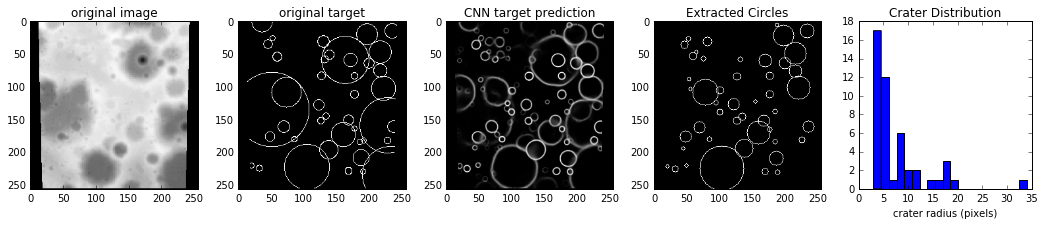

In [67]:
f, ax = plt.subplots(1,5, figsize=[18, 3])

ax[0].imshow(test_data[i].reshape(dim,dim), origin='upper', cmap="Greys_r")   #original image
ax[1].imshow(test_target[i].reshape(dim,dim), origin='upper', cmap="Greys_r")   #original ground truth
ax[2].imshow(target[i], origin='upper', cmap="Greys_r")   #predictions
ax[0].set_title('original image')
ax[1].set_title('original target')
ax[2].set_title('CNN target prediction')

mask = np.zeros((dim,dim))
radii_dist = []
for c in coords:
    x,y,r = c
    cv2.circle(mask, (x,y), r, 1, 1)
    radii_dist.append(r)
ax[3].imshow(mask, origin='upper', cmap="Greys_r")
ax[3].set_title('Extracted Circles')
ax[4].hist(radii_dist, 20)
ax[4].set_title('Crater Distribution')
ax[4].set_xlabel('crater radius (pixels)')
plt.savefig('output_dir/images/target_thresh=0.15.png')

## Load model and analyze predictions
Read in your model predictions that were generated remotely on scinet, so you can analyze the predictions locally. The option is also available to perform a template match and extract the crater distribution from each image (but takes longer).

In [2]:
#location of your predicted images
pred_extension = "models/*_pred.npy"

files = glob.glob(pred_extension)
zip(np.arange(len(files)), files)

[(0, 'models/unet_s256_rings_FL3_glorot_normal_pred.npy'),
 (1, 'models/unet_s256_rings_FL3_he_normal_customloss_pred.npy'),
 (2, 'models/unet_s256_rings_FL3_he_normal_pred.npy'),
 (3, 'models/unet_s256_rings_FL3_he_uniform_pred.npy'),
 (4, 'models/unet_s256_rings_FL3_pred.npy'),
 (5, 'models/unet_s256_rings_FL3_predfull_pred.npy'),
 (6, 'models/unet_s256_rings_FL3_weightedpred_pred.npy'),
 (7, 'models/unet_s256_rings_FL5_glorot_normal_pred.npy'),
 (8, 'models/unet_s256_rings_FL5_he_uniform_pred.npy'),
 (9, 'models/unet_s256_rings_FL5_pred.npy'),
 (10, 'models/unet_s256_rings_lmbda1.000000e-06_pred.npy'),
 (11, 'models/unet_s256_rings_lmbda1.000000e-07_pred.npy')]

In [3]:
#if multiple predictions, choose which one you want to load from the list
model_i=6

data = np.load(files[model_i])
dim = data.shape[1]
print "loaded model predictions: %s"%files[model_i]

loaded model predictions: models/unet_s256_rings_FL3_weightedpred_pred.npy


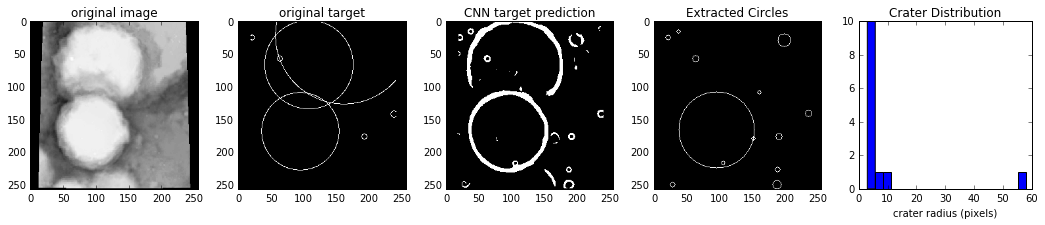

In [7]:
#parameters
img_i=3               #image index you want to run
get_crater_dist = 1    #1 = get crater distribution for img_i. Will take longer.

#analysis and plot
f, ax = plt.subplots(1,3+2*get_crater_dist, figsize=[11+7*get_crater_dist, 3])
ax[0].imshow(data[img_i,:,:,0], origin='upper', cmap="Greys_r")   #original image
ax[1].imshow(data[img_i,:,:,1], origin='upper', cmap="Greys_r")   #original ground truth
ax[2].imshow(data[img_i,:,:,2], origin='upper', cmap="Greys_r")   #predictions
ax[0].set_title('original image')
ax[1].set_title('original target')
ax[2].set_title('CNN target prediction')
#plot circles and make radius distribution
if get_crater_dist == 1:
    coords = template_match_target(data[img_i,:,:,2])
    mask = np.zeros((dim,dim))
    radii_dist = []
    for c in coords:
        x,y,r = c
        cv2.circle(mask, (x,y), r, 1, 1)
        radii_dist.append(r)
    ax[3].imshow(mask, origin='upper', cmap="Greys_r")
    ax[3].set_title('Extracted Circles')
    ax[4].hist(radii_dist, 20)
    ax[4].set_title('Crater Distribution')
    ax[4].set_xlabel('crater radius (pixels)')

plt.savefig('output_dir/images/%d_%s.png'%(img_i,os.path.basename(files[model_i]).split('.npy')[0]))

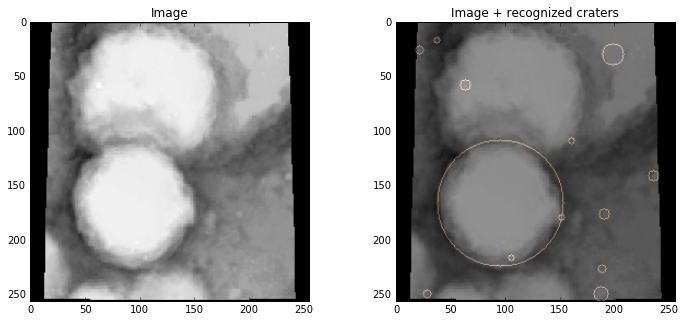

In [8]:
#plot just original image and extracted circles
img_i=3               #image index you want to run

f, ax = plt.subplots(1,2, figsize=[12, 5])
ax[0].imshow(data[img_i,:,:,0], origin='upper', cmap="Greys_r")
ax[1].imshow(data[img_i,:,:,0], origin='upper', cmap="Greys_r")
coords = template_match_target(data[img_i,:,:,2])
mask = np.zeros((dim,dim))
radii_dist = []
for c in coords:
    x,y,r = c
    cv2.circle(mask, (x,y), r, 1, 1)
ax[1].imshow(mask, origin='upper', cmap="copper",alpha=0.4)
ax[0].set_title('Image')
ax[1].set_title('Image + recognized craters')
plt.savefig('output_dir/images/overplot_%d_%s.png'%(img_i,os.path.basename(files[model_i]).split('.npy')[0]))

## Plot custom loss vs. epoch

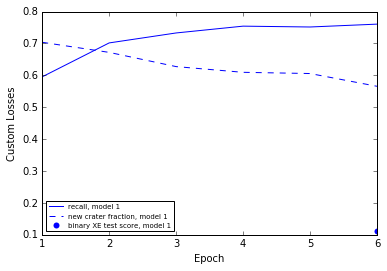

In [9]:
filename = 'output_dir/unet_s256_rings_pred_weighted_new.txt'     #output file from model training

recall, new_craters, N_models = [], [], 0
lines = open(filename, 'r').readlines()
for line in lines:
    if "mean and std of N_match/N_csv (recall) =" in line:
        recall.append(float(line.split(' = ')[1].split(",")[0]))
    elif "(N_template - N_match)/N_template" in line:
        new_craters.append(float(line.split(' = ')[1].split(",")[0]))
    elif "Test Score is" in line:
        N_models += 1
        test_score, n_epochs = float(line.split('Test Score is')[1]), len(recall)
        p = plt.plot(np.arange(n_epochs)+1, recall, label='recall, model %d'%N_models)
        plt.plot(np.arange(n_epochs)+1, new_craters, linestyle="--", color=p[0].get_color(), label='new crater fraction, model %d'%N_models)
        plt.plot(n_epochs, test_score, 'o', color=p[0].get_color(), mew=0, label='binary XE test score, model %d'%N_models)
        plt.legend(loc='lower left',fontsize=7, numpoints=1)
        recall, new_craters = [], []

plt.xlabel('Epoch')
plt.ylabel('Custom Losses')

# Plot pixel intensities

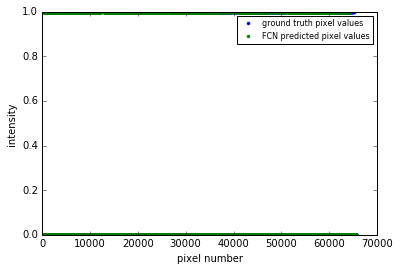

In [18]:
img_i=1
plt.plot(data[img_i,:,:,1].reshape(dim*dim), '.', label='ground truth pixel values')
plt.plot(data[img_i,:,:,2].reshape(dim*dim), '.', label='FCN predicted pixel values')
plt.xlabel('pixel number')
plt.ylabel('intensity')
plt.legend(fontsize=8, numpoints=1)